# Info: 
#### Topics: Clustering and PCA on the fraud detection
#### Team Members: Zecheng Li, Lechuan Wang, Yifan Lin, Zhenyi Chen, Qianxi Gong, Gongyi Qu, Yicheng Qu
#### We use the data from https://www.kaggle.com/c/ieee-fraud-detection/overview, which provides (joined by TransactionID):
- `test_identity.csv`
- `test_transaction.csv`
- `train_identity.csv`
- `train_transaction.csv`
- `sample_submission.csv`

#### Categorical Features - Transaction
- `ProductCD`
- `card1 - card6`
- `addr1, addr2`
- `P_emaildomain`
- `R_emaildomain`
- `M1 - M9`

#### Categorical Features - Identity
- `DeviceType`
- `DeviceInfo`
- `id_12 - id_38`

#### We will focus on making predictive models from the training data, i.e. `train_identity.csv` and `train_transaction.csv`, and then applying the models to the test data and uploading the results, i.e. `isFraud`, to https://www.kaggle.com/c/ieee-fraud -detection/submit to see the score(accuracy).

#### We look for some data cleaning tips from https://www.kaggle.com/c/ieee-fraud-detection/code

# Import Libraries

In [1]:
# using operating system dependent functionality.
import os
#  various time-related functions
import time
# fundamental package for scientific computing with Python
import numpy as np
# data manipulation and analysis
import pandas as pd

In [2]:
# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load Data

In [3]:
# get current path
folder_path = os.getcwd()

# load raw dataset
train_identity = pd.read_csv(f'{folder_path}/train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}/train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}/test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}/test_transaction.csv')
# sub = pd.read_csv(f'{folder_path}/sample_submission.csv')
# merge data
train_data = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test_data = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [4]:
# make test data columns consistent with train data
test_data = test_data.rename(dict(zip([i for i in test_data if 'id' in i], [i for i in train_data if 'id' in i])), axis = 1)

In [5]:
# remove unnecessary files to save memories
del train_identity, train_transaction, test_identity, test_transaction

# Data EAD

### View

In [6]:
train_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [7]:
test_data.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


Variables Descriptions

**From Transaction Table**

`Continuous`
- **TransactionDT**: timedelta from a given reference datetime (not an actual timestamp)
- **TransactionAMT**: transaction payment amount in USD
- **dist**: distance
- **C1-C14**: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- **D1-D15**: timedelta, such as days between previous transaction, etc.
- **Vxxx**: Vesta engineered rich features, including ranking, counting, and other entity relations.

`Categorical Features`:
- **ProductCD**: product code, the product for each transaction
- **card1 - card6**: payment card information, such as card type, card category, issue bank, country, etc.
- **addr1, addr2**: address
- **P_emaildomain**: purchaser email domain
- **R_emaildomain**: recipient email domain
- **M1 - M9**:  match, such as names on card and address, etc.

**From Identity Table**

- identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

`Categorical Features`:
- **DeviceType**
- **DeviceInfo**
- **id_12 - id_38**x

### Shape

In [9]:
print('There are', train_data.shape[0], 'obervations', 'and',  train_data.shape[1], 'features in the train data set.')

There are 590540 obervations and 434 features in the train data set.


In [10]:
print('There are', test_data.shape[0], 'obervations', 'and',  test_data.shape[1], 'features in the test data set.')

There are 506691 obervations and 433 features in the test data set.


### Check Null 

#### - train data

In [11]:
train_null = pd.DataFrame(train_data.isnull().sum().sort_values(ascending=False) / train_data.shape[0])\
                .reset_index().rename({'index':'features', 0:'null percentage'}, axis = 1)

total_train_na = len(train_null[(train_null['null percentage'] > 0)])

print('There are', test_data.shape[1], 'features', 'while',  total_train_na, 'features contains Null in the train data set.')
train_null

There are 433 features while 414 features contains Null in the train data set.


,features,null percentage
0,id_24,0.991962
1,id_25,0.991310
2,id_07,0.991271
3,id_08,0.991271
4,id_21,0.991264
...,...,...
429,C3,0.000000
430,C2,0.000000
431,C1,0.000000
432,isFraud,0.000000


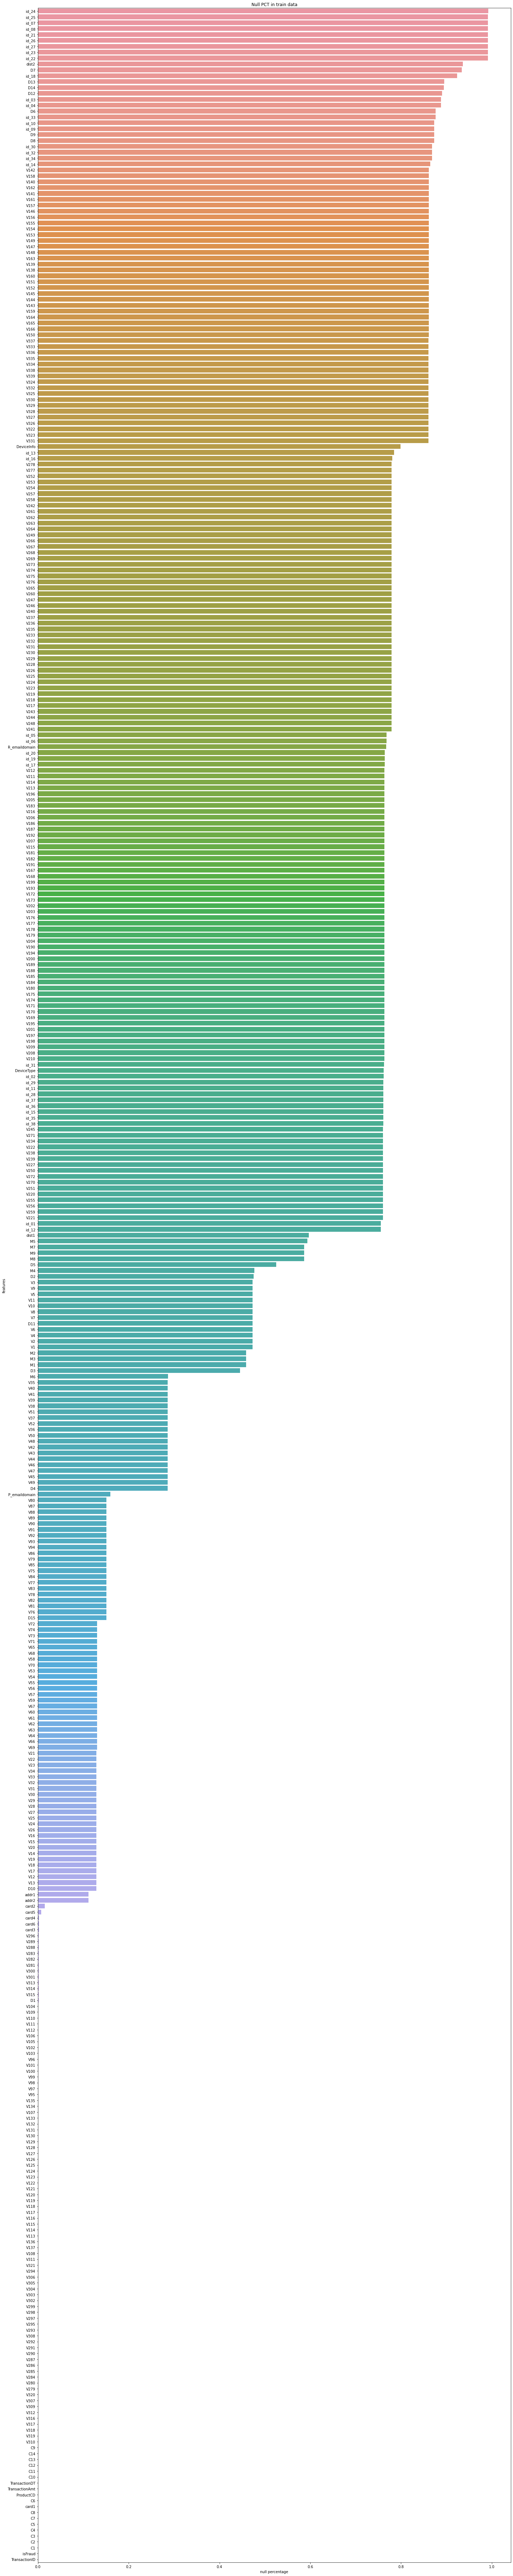

In [12]:
plt.figure(figsize=(20, 100))
# use seaborn to draw bar plot
sns.barplot(y ="features", x = "null percentage", data = train_null, capsize = 0)
plt.title('Null PCT in train data')
# Adjust the padding between and around subplots.
plt.tight_layout()
plt.show()

As we can see from the bar plot, most features contain Null Value, and many contains 90% of their total data, which is ubiquitous in real world.

#### - test data

In [13]:
test_null = pd.DataFrame(test_data.isnull().sum().sort_values(ascending=False) / test_data.shape[0])\
                    .reset_index().rename({'index':'features', 0:'null percentage'}, axis = 1)

total_test_na = len(test_null[(test_null['null percentage'] > 0)])

print('There are', test_data.shape[1], 'features', 'while',  total_test_na, 'features contains Null in the test data set.')
test_null

There are 433 features while 385 features contains Null in the test data set.


,features,null percentage
0,id_24,0.990645
1,id_25,0.990055
2,id_26,0.990039
3,id_21,0.990016
4,id_08,0.990016
...,...,...
428,V113,0.000000
429,V114,0.000000
430,V115,0.000000
431,V116,0.000000


### Check High Contains

#### - train data

In [14]:
high_contains_value_cols_train = [col for col in train_data.columns if train_data[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [15]:
high_contains_train_df = pd.DataFrame([train_data[col].value_counts(dropna=False, normalize=True).values[0] for col\
                          in high_contains_value_cols_train], 
                         high_contains_value_cols_train).reset_index().rename({'index':'features', 0:'one obeservation pct'}, axis = 1)
high_contains_train_df

,features,one obeservation pct
0,isFraud,0.965010
1,dist2,0.936284
2,C3,0.995887
3,D7,0.934099
4,V98,0.945951
...,...,...
62,id_23,0.991247
63,id_24,0.991962
64,id_25,0.991310
65,id_26,0.991257


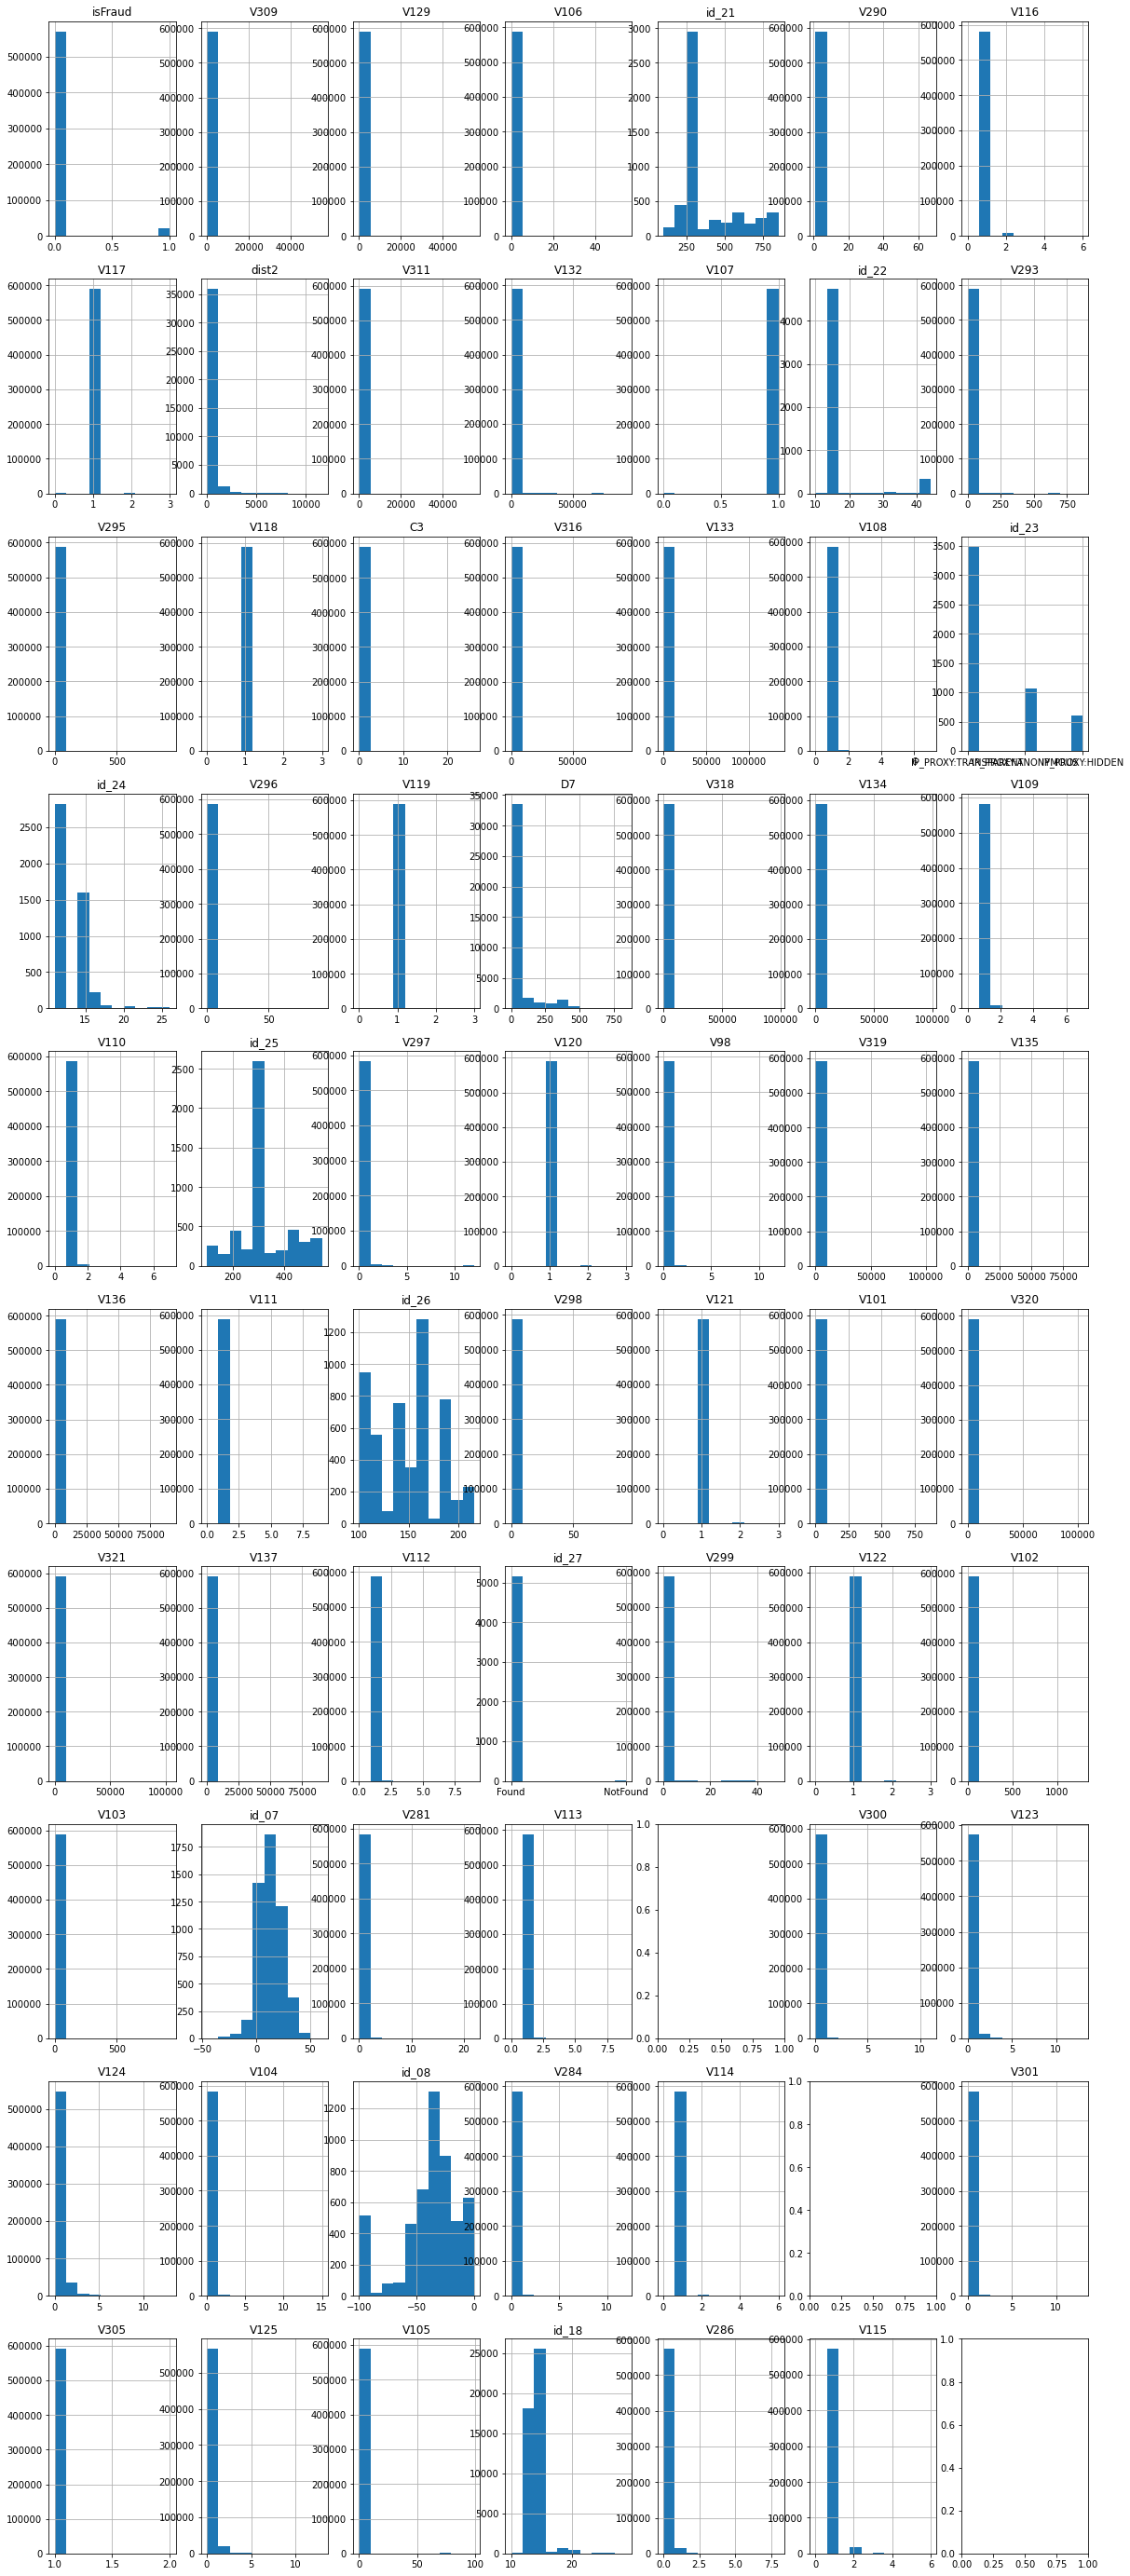

In [16]:
fig, axs = plt.subplots(10, 7, figsize = (20, 50))
a = 0
b = 0

for i in high_contains_value_cols_train:
    try:
        train_data[i].hist(ax=axs[a%10, b%7])
        axs[a%10][b%7].set_title(i)
    except:
        print(i)
    a+=1
    b+=1
    

In [17]:
train_data['id_25'].value_counts(dropna=False, normalize=True)

NaN      0.991310
321.0    0.004223
205.0    0.000510
426.0    0.000400
501.0    0.000174
           ...   
139.0    0.000002
469.0    0.000002
342.0    0.000002
304.0    0.000002
189.0    0.000002
Name: id_25, Length: 342, dtype: float64

#### - test

In [18]:
high_contains_value_cols_test = [col for col in test_data.columns if test_data[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [19]:
high_contains_test_df = pd.DataFrame([test_data[col].value_counts(dropna=False, normalize=True).values[0] for col\
                          in high_contains_value_cols_test], 
                         high_contains_value_cols_test).reset_index().rename({'index':'features', 0:'one obeservation pct'}, axis = 1)
high_contains_test_df

,features,one obeservation pct
0,dist2,0.928090
1,C3,0.974517
2,V14,0.975004
3,V23,0.938671
4,V24,0.920683
...,...,...
74,id_23,0.990010
75,id_24,0.990645
76,id_25,0.990055
77,id_26,0.990039


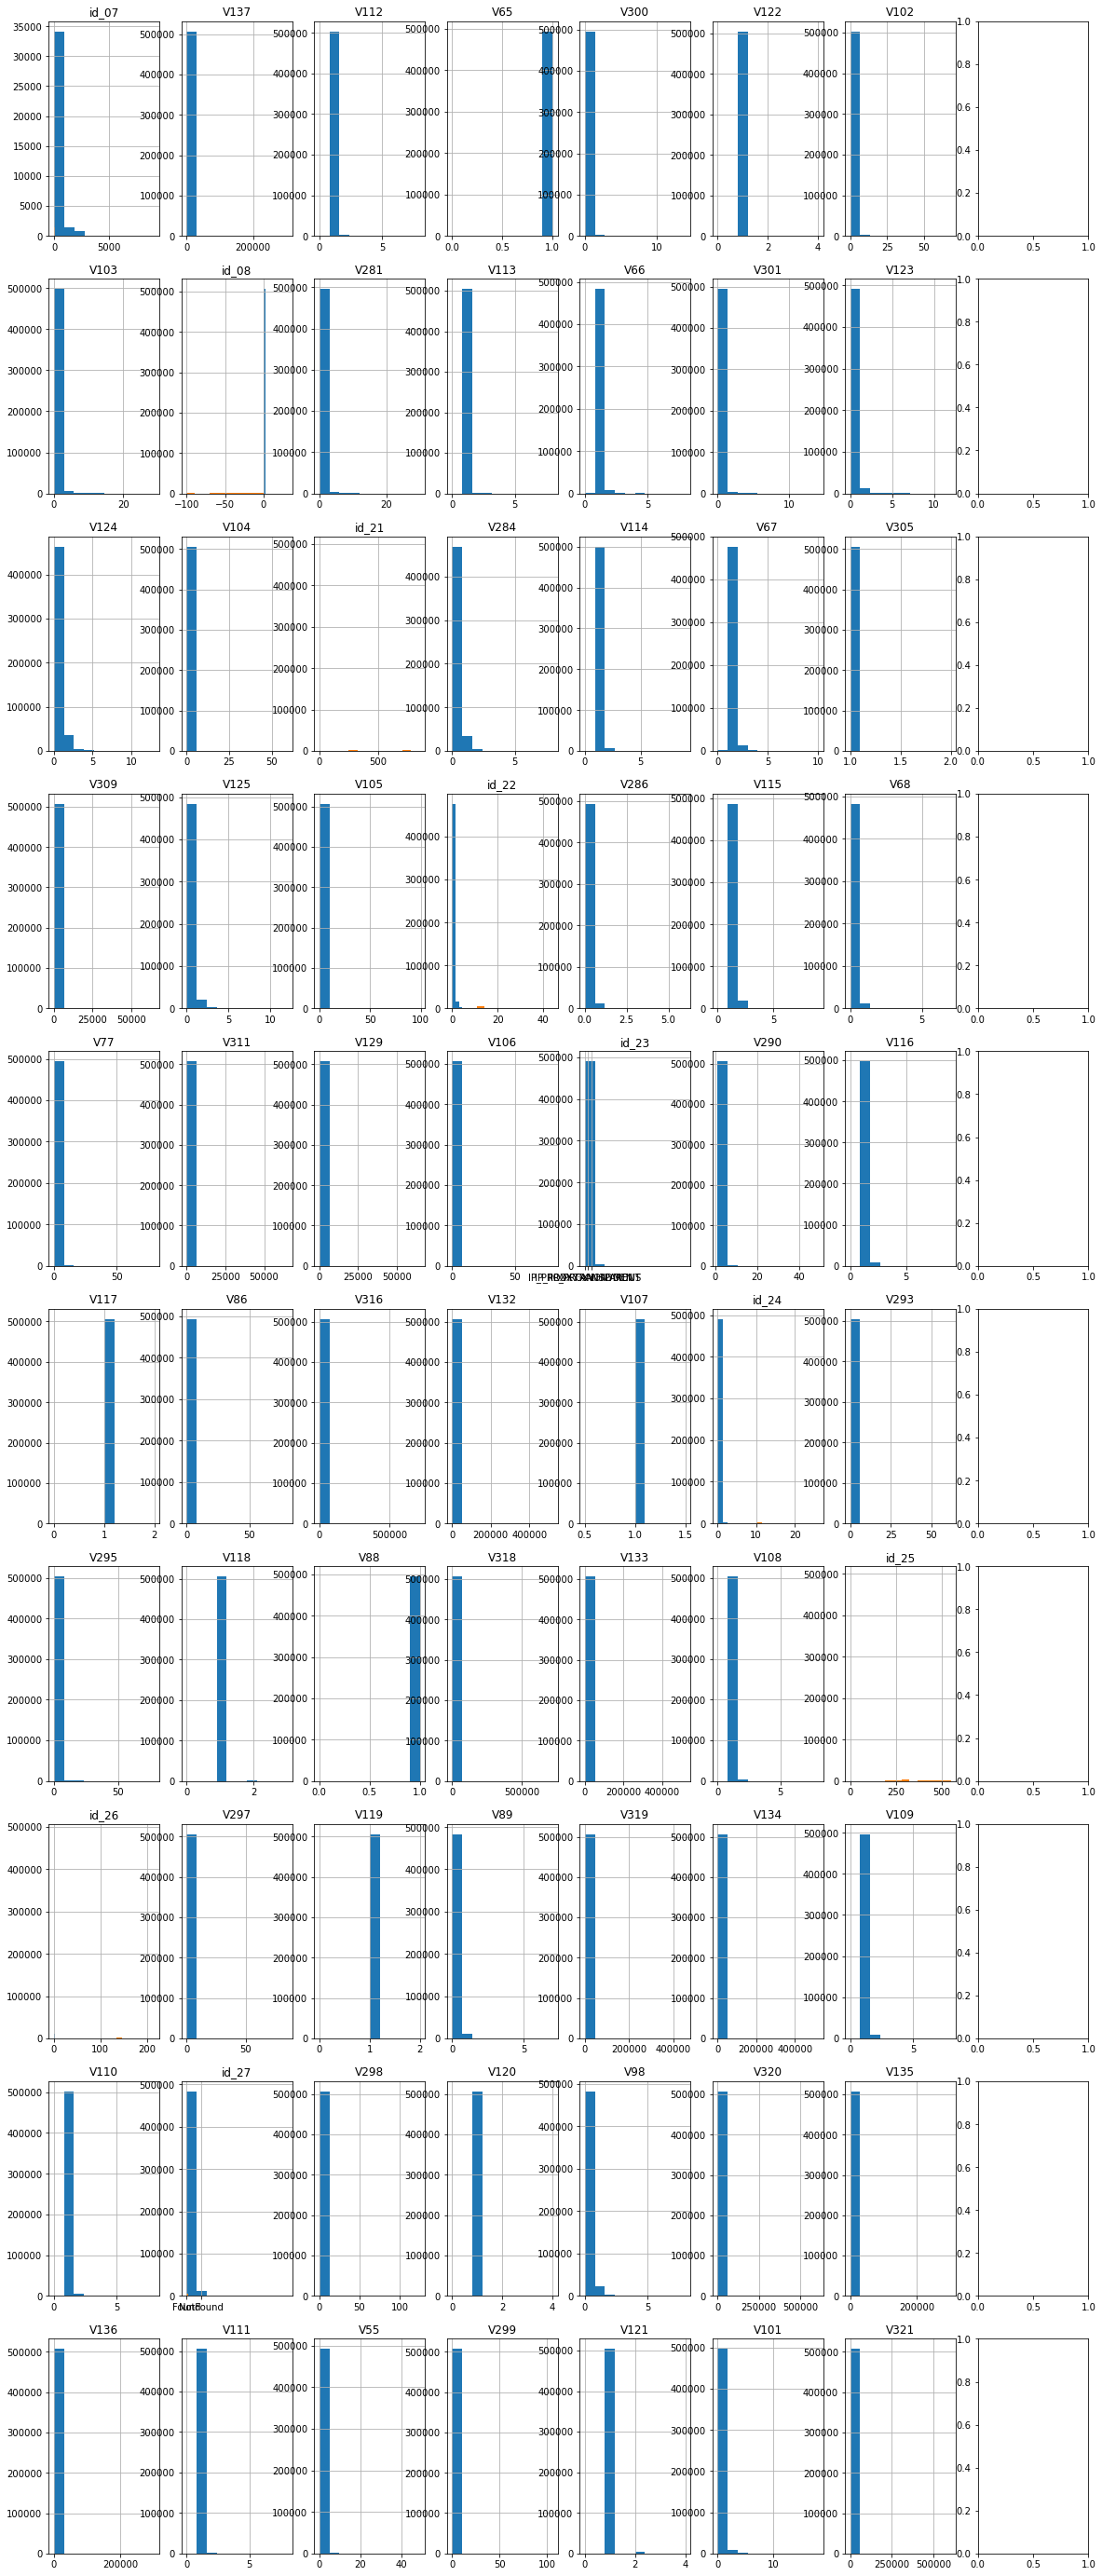

In [20]:
fig, axs = plt.subplots(10, 8, figsize = (20, 50))
a = 0
b = 0

for i in high_contains_value_cols_test:
    try:
        test_data[i].hist(ax=axs[a%10, b%7])
        axs[a%10][b%7].set_title(i)
    except:
        print(i)
    a+=1
    b+=1

### Check Only One Variable

#### - train

In [21]:
unique_train_df = pd.DataFrame([train_data[col].nunique() for col in train_data.columns],
                      train_data.columns).reset_index().rename({'index':'features', 0:'unique observations'}, axis = 1)


In [22]:
unique_train_df[unique_train_df['unique observations'] <= 1]

,features,unique observations


Lukily, for the train dataset, there are no columns that only contains 1 obervation.

#### - test

In [23]:
unique_test_df = pd.DataFrame([test_data[col].nunique() for col in test_data.columns],
                    test_data.columns).reset_index().rename({'index':'features', 0:'unique observations'}, axis = 1)



In [24]:
unique_test_df[unique_test_df['unique observations'] <= 1]

,features,unique observations
160,V107,1


There's only 1 feature that have 1 unique observations in test dataset. Let's see its distribution.

array([[<AxesSubplot:title={'center':'V107'}>]], dtype=object)

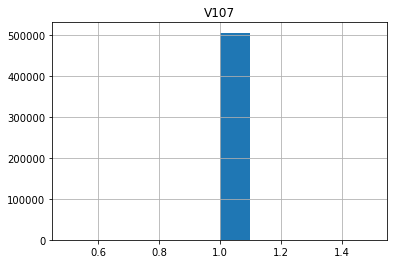

In [25]:
test_data.hist('V107')

In [26]:
test_data['V107'].value_counts()

1.0    506691
Name: V107, dtype: int64

### Variables Exploration

In [27]:
pd.DataFrame(train_data['isFraud'].value_counts())

,isFraud
0,569877
1,20663


In [28]:
train_data.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


### Clean Data
- some reference from https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt

**- Drop High Contains Null Cols**

In [29]:
train_null.head()

,features,null percentage
0,id_24,0.991962
1,id_25,0.991310
2,id_07,0.991271
3,id_08,0.991271
4,id_21,0.991264


In [30]:
null_cols_train = list(train_null[train_null['null percentage'] > 0.9]['features'])
null_cols_test = list(test_null[test_null['null percentage'] > 0.9]['features'])

**- Drop Cols if its 1 obersvation domains all (contains > 90%)**

In [31]:
high_contains_train_df.head()

,features,one obeservation pct
0,isFraud,0.965010
1,dist2,0.936284
2,C3,0.995887
3,D7,0.934099
4,V98,0.945951


In [32]:
high_cols_train = list(high_contains_train_df[high_contains_train_df['one obeservation pct'] > 0.9].features)
high_cols_test = list(high_contains_test_df[high_contains_test_df['one obeservation pct'] > 0.9].features)


**- Drop Cols if it only contains 1 variable**

In [33]:
unique_test_df[unique_test_df['unique observations'] <= 1]

,features,unique observations
160,V107,1


In [34]:
unique_cols_train = list(unique_train_df[unique_train_df['unique observations'] <= 1].features)
unique_cols_test = list(unique_test_df[unique_test_df['unique observations'] <= 1].features)

In [35]:
total_cols_drop = list(set(null_cols_train+null_cols_test+high_cols_train+high_cols_test+unique_cols_test+unique_cols_train))
# remove Y
total_cols_drop.remove('isFraud')
print('We are gonna to drop ', len(total_cols_drop), ' features')

We are gonna to drop  82  features


In [36]:
train_data = train_data.drop(total_cols_drop, axis=1)
test_data = test_data.drop(total_cols_drop, axis=1)

In [37]:
print(train_data.shape)
print(test_data.shape)

(590540, 352)
(506691, 351)


Now we still not ready to use the data for modeling, we need to turn the categorized features into numeric.

**- Transform categorized features**

In [38]:
train_data.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
                   ...   
id_36              object
id_37              object
id_38              object
DeviceType         object
DeviceInfo         object
Length: 352, dtype: object

In [39]:
train_data['id_36'].dtype
# categorical data in train data is identical with that in test data
categorical_cols = [i for i in train_data.columns if train_data[i].dtype == 'object']

In [40]:
# ['a','c','v', 'a']

# [0, 1, 2, 0]  model 

# matrix @ matrix 

We will use `preprocessing` from sklearn

In [41]:
from sklearn import preprocessing
# label_encoder  
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Embarked'. 
print('we will transform the categorical data: ', train_data.ProductCD.unique(), 'to', \
      label_encoder.fit_transform(train_data['ProductCD']))

we will transform the categorical data:  ['W' 'H' 'C' 'S' 'R'] to [4 4 4 ... 4 4 4]


In [42]:
for i in categorical_cols:
    # label_encoder  
    label_encoder = preprocessing.LabelEncoder()
    # to fit the enocder to the total of train data and test data
    label_encoder.fit(list(train_data[i].values) + list(test_data[i].values))
    train_data[i] = label_encoder.transform(list(train_data[i].values))
    test_data[i] = label_encoder.transform(list(test_data[i].values))  

### Separate X & Y

- We will use `train_test_split` from sklearn.model_selection
- We will separate the train dataset to create a train set and validation set

In [43]:
from sklearn.model_selection import train_test_split
# isFraud is Y and we won't use TransactionDT and TransactionID 
# since their are confidential personal identical variable
X = train_data.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train_data.sort_values('TransactionDT')['isFraud']
# for the kaggle invisible test
X_test = test_data.drop(['TransactionDT', 'TransactionID'], axis=1)
# confusion  matrix


Data still have Null values, we set the Null values to each column's minmum vakue - 2

In [44]:
for col in X.columns: #-999
    X[col] = X[col].fillna((X[col].min() - 2))

In [45]:
for col in X_test.columns:
    X_test[col] = X_test[col].fillna((X_test[col].min() - 2))

In [46]:
print(X.shape)
print(y.shape)
print(X_test.shape)

(590540, 349)
(590540,)
(506691, 349)


In [47]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [48]:
# del X_train, X_val, y_train, y_val

In [49]:
# # prepocessing 
# - null
# - categ

# PCA

In [50]:
from sklearn.preprocessing import normalize

In [51]:
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort


# normc(M) normalizes the columns of M to a length of 1.
def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

In [52]:
def pca(X, n_component):
    mean_X = np.mean(X, axis = 1)[:,None]
    A = X - mean_X
    eigenvalues, eigenvectors = np.linalg.eig(A.T @ A)
    V, D = eigsort(eigenvectors, eigenvalues)
    U = normc(A @ V)
    return pd.DataFrame(U[:, :n_component]).rename(dict(zip([i for i in range(0, n_component)], [str(i)+" component" for i in range(1, n_component+1)])), axis = 1)


In [53]:
mean_X = np.mean(X, axis = 1)[:,None]
A = X - mean_X
eigenvalues, eigenvectors = np.linalg.eig(A.T @ A)
V, D = eigsort(eigenvectors, eigenvalues)
U = normc(A @ V)

<ipython-input-53-094df1db7863>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mean_X = np.mean(X, axis = 1)[:,None]


In [54]:
print(X.shape)
U.shape

(590540, 349)


(590540, 349)

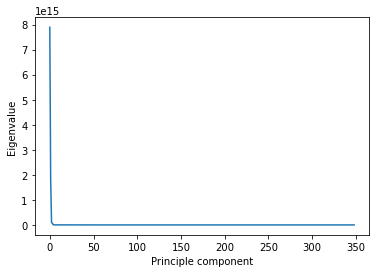

In [55]:
# plt.figure(figsize=(200, 100))
Eigen = []
for i in range(349):
    Eigen.append(D[i][i])

x = range(len(X.columns))
plt.plot(x , Eigen)
plt.ylabel("Eigenvalue")
plt.xlabel("Principle component")

plt.show()

In [ ]:
# X auc 

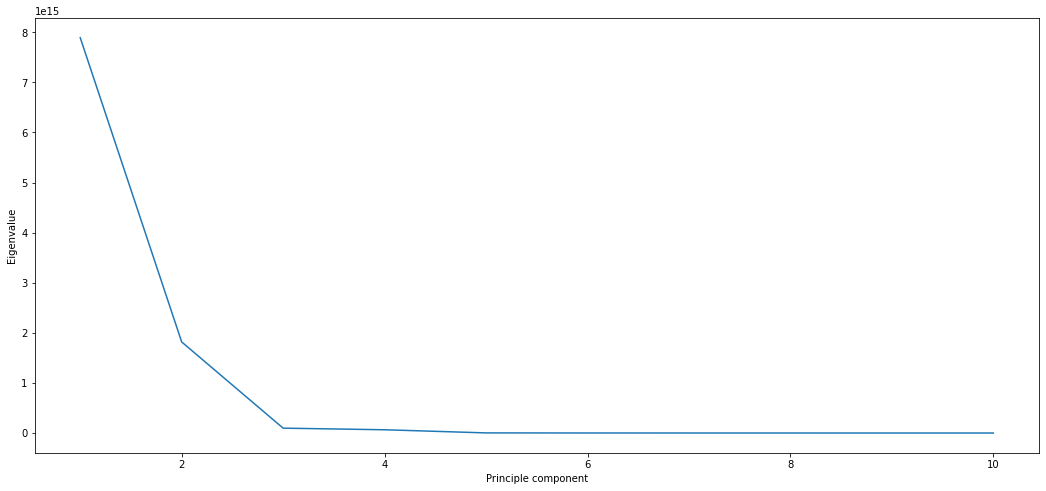

In [56]:
plt.figure(figsize=(18, 8))
Eigen = []
for i in range(10):
    Eigen.append(D[i][i])

x = range(1,11)
plt.plot(x , Eigen)
plt.ylabel("Eigenvalue")
plt.xlabel("Principle component")

plt.show()

As we can see in the figure above, the first two principle components have a large variation compared to the other components. We can use the first 30 principle components to explain the majority of the data.

In [57]:
%%time
print(X.shape)
# pca 30
X_pca_30 = pca(X, 30)

(590540, 349)


<ipython-input-52-5ee655de019e>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mean_X = np.mean(X, axis = 1)[:,None]


CPU times: user 15.2 s, sys: 18 s, total: 33.2 s
Wall time: 38.4 s


In [58]:
X_pca_30.head()

,1 component,2 component,3 component,4 component,5 component,6 component,7 component,8 component,9 component,10 component,...,21 component,22 component,23 component,24 component,25 component,26 component,27 component,28 component,29 component,30 component
0,4.513445e-06,-3.514594e-06,-0.000224,0.001721,0.000042,-0.000054,-0.000087,0.000042,-0.000090,-0.000338,...,-0.000054,-0.000161,-0.000115,0.000398,0.000114,0.000091,0.000066,0.000339,-0.000581,-0.001527
1,9.921950e-07,-6.662885e-07,-0.000047,0.000405,0.000010,0.000058,0.000003,0.000035,0.000475,0.002183,...,-0.000015,-0.000388,-0.000071,0.000579,0.000164,0.000058,0.000021,0.000053,-0.000142,-0.000194
2,1.552315e-06,-1.068704e-06,-0.000074,0.000631,0.000022,0.000035,-0.000023,0.000044,0.000376,0.001804,...,0.000195,0.000872,-0.001018,0.000399,0.000126,0.000016,0.000129,-0.000028,-0.000036,0.000296
3,5.543693e-06,-3.972139e-06,-0.000466,0.002190,-0.000621,0.000769,0.000385,-0.000036,0.000017,-0.001202,...,-0.000176,-0.001098,-0.000786,-0.000317,0.001288,0.000496,-0.000348,0.002340,0.000521,0.000833
4,8.989651e-04,-3.885885e-03,0.000015,-0.000020,-0.000064,-0.000082,-0.001406,-0.005514,0.000792,0.000635,...,-0.000129,0.000213,0.000859,0.002792,-0.002150,-0.003002,0.001040,0.001352,-0.003484,0.003494


Text(0.5, 1.0, 'Separation of Observations using PCA')

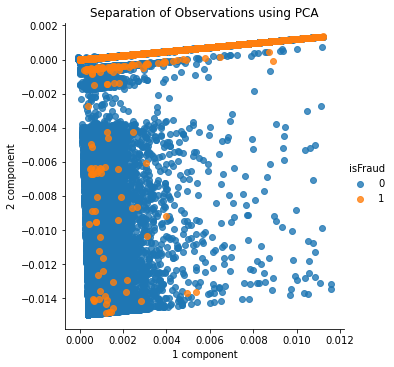

In [59]:
pca_30_df = pd.concat((X_pca_30[['1 component', '2 component']], y),\
                      axis=1, join="inner")

sns.lmplot(x='1 component', y='2 component', hue = 'isFraud'\
           , data = pca_30_df, fit_reg=False)
ax = plt.gca()
ax.set_title("Separation of Observations using PCA")

In [60]:
del pca_30_df

From the figure above, PCA seems to do a good job of separating the data when we consider only the first two components selected to represent the data.

# Functions
- build unsupervised learning algorithms from scrach
- Use supervised learning algorithms from sklearn and other packages


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from math import pi
from sklearn import metrics

In [62]:
X_test_pca_30 = pca(X_test, 30)

<ipython-input-52-5ee655de019e>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mean_X = np.mean(X, axis = 1)[:,None]


In [63]:
print(X_test_pca_30.shape)
print(X_pca_30.shape)

(506691, 30)
(590540, 30)


In [64]:
class KMeans:
    '''
    KMeans clustering algorithm
    '''
    def __init__(self, X, K):
        if not isinstance(X, (np.ndarray, np.generic)):
            X = X.to_numpy()
        self.X = X
        self.K = K
        self.Kmus = None

    def runKMeans(self):
        '''
        return kmus with K demensions
        '''
        X = self.X
        K = self.K

        #determine and store data set information
        N, D = X.shape

        #allocate space for the K mu vectors
        Kmus = np.zeros((K, D))

        #initialize cluster centers by randomly picking points from the data
        rand_inds = np.random.permutation(N)
        Kmus = X[rand_inds[0:K],:]

        #specify the maximum number of iterations to allow
        maxiters = 600

        for iter in range(maxiters):
           
            #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
            sqDmat = self.calcSqDistances(Kmus)

            #given the matrix of squared distances, determine the closest cluster
            #center for each data vector

            #R is the "responsibility" N-by-K matrix
            Rnk = self.determineRnk(sqDmat)
            KmusOld = Kmus

            #recalculate mu values based on cluster assignments as per Bishop (9.4)
            Kmus = self.recalcMus(Rnk)

            #check to see if the cluster centers have converged.  If so, break.
            if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-6:
                break
                
        self.Rnk = Rnk
        self.Kmus = Kmus
        return Kmus


    def calcSqDistances(self, Kmus):
        # distance from the cluster
        X = self.X
#         x_r, x_c = X.shape
#         k_r, k_c = Kmus.shape
#         output = np.zeros((x_r, k_r), dtype = np.float16)
#         for i in range(x_r):
#             for j in range(k_r):
#                 output[i,j] = np.linalg.norm(X[i] - Kmus[j])

        return distance = np.linalg.norm(X-Kmus[:,None], axis =-1).T


    def determineRnk(self, sqDmat):
        #R is the "responsibility" matrix
        Output = np.zeros((sqDmat.shape))
        for i in range(len(sqDmat)):
            m = np.argmin(sqDmat[i])
            Output[i, m] = 1

        return Output

    def recalcMus(self, Rnk):
        #recalculate mu values 
        X = self.X
        r_r, r_c = Rnk.shape
        x_r, x_c = X.shape

        divisor = X.T @ Rnk
        divident = np.sum(Rnk, axis=0)
        return np.divide(divisor, divident).T

    def predict(self, X):
        '''
        prediction
        '''
        if self.Kmus is None:
            raise
        if X.shape[1] != self.X.shape[1]:
            raise
        
        if not isinstance(X, (np.ndarray, np.generic)):
            X = X.to_numpy()
            
        centroids = self.Kmus
        cluster = np.zeros(X.shape[0])
        for i, row in enumerate(X):
            min_dist = float('inf')
            # distance of each point from all centroids
            for idx, centroid in enumerate(centroids):
                d = np.sqrt((centroid[0]-row[0])**2 + (centroid[1]-row[1])**2)
                # store closest centroid
                if min_dist > d:
                    min_dist = d
                    cluster[i] = idx

        if  (cluster == 0).sum() < (cluster == 1).sum():
            cluster = 1 - cluster
        return cluster


In [65]:
class GMM:
    '''
    GMM clustering algorithm
    '''
    def __init__(self, K):
        self.K = K

    def runGMM(self, X, mu0, sigma0):#, phi0, mu0, sigma0):
        if not isinstance(X, (np.ndarray, np.generic)):
            X = X.to_numpy()
        K = self.K
        # initilize
        phi0 = np.asarray([1/K] * K)

        #determine and store data set information
        N, D = X.shape

        #specify the maximum number of iterations to allow
        maxiters = 1000

        Gamma = np.zeros((N,K))
        
        for iter in range(maxiters):

            #allocate space for the K mu and sigma vectors
            Kmus = np.zeros((K, D))
            Sigma = np.zeros((K, D))

            # E step
            # calculate Gamma vectors 
            Gamma = self.calcRespons(X, phi0, mu0, sigma0)

            # M step, recalcParams

            #calculate phi
            phi = np.sum(Gamma, axis = 0) / N

            # store Kmus
            for i in range(K):
                Kmus[i] = np.divide((Gamma.T @ X)[i], np.sum(Gamma[:,i]))

            # store Sigma
            for i in range(K):
                Sigma[i] = np.divide((Gamma[:,i].T @ ((X - Kmus[i])**2)), np.sum(Gamma[:,i]))
                Sigma[Sigma < 0.01] = 0.01

            # check convergence
            if np.sum(np.abs(mu0.reshape((-1,1)) - Kmus.reshape((-1,1)))) < 1e-3:
                break

            # reassign values to repeat whole
            # progress untill converge
            print(f"phi is : {phi}")
            print(f"Kmus is : {Kmus}")
            print(f"Sigma is : {Sigma}")
            phi0, mu0, sigma0 = phi, Kmus, Sigma

        self.GAMMA = Gamma
        self.phi = phi0
        self.mu = mu0
        self.sigma = sigma0
        return phi0, mu0, sigma0


    def calcRespons(self, X, phi0, mu0, sigma0):
        a = np.zeros((X.shape[0], 2))
        for i in range(2):
            a[:,i] = phi0[i] * self.gaussian(X, mu0[i], np.diag(sigma0[i]))
        b = np.sum(a, axis = 1, keepdims = True)
        return np.divide(a,b)


    # multivariate_normal(self, X, mean_vector, covariance_matrix)
    def gaussian(self, X, mu, cov):
        x = X
        d = np.shape(x)[1]
        mu = mu[None, :]
        dr = 1 / (np.sqrt((2 * pi)**(d) * np.linalg.det(cov)))
        nr = (np.exp(-np.diag((x-mu)@(np.linalg.inv(cov)) @ ((x-mu).T / 2))))
        return nr * dr

    def predict(self, X):
        '''
            The predicting function
                :param X: 2-d array numpy array
                    The data on which we must predict the clusters
        '''
        probas = []
        for n in range(len(X)):
            probas.append([self.gaussian(X[n], self.mu[k], self.sigma[k])
                           for k in range(self.K)])

        cluster = probas.argmax(axis=1)
        if  (cluster == 0).sum() < (cluster == 1).sum():
            cluster = 1 - cluster
        return cluster

In [66]:
def plotCurrent(X, Rnk, Kmus):
    N, D = X.shape
    K = Kmus.shape[0]

    InitColorMat = np.array([[1, 0, 0],
                             [0, 1, 0],
                             [0, 0, 1],
                             [0, 0, 0],
                             [1, 1, 0],
                             [1, 0, 1],
                             [0, 1, 1]])

    KColorMat = InitColorMat[0:K,:]

    colorVec = np.dot(Rnk, KColorMat)
    muColorVec = np.dot(np.eye(K), KColorMat)
    plt.scatter(X[:,0], X[:,1], c=colorVec)

    plt.scatter(Kmus[:,0], Kmus[:,1], s=200, c=muColorVec, marker='d')
    plt.axis('equal')
    plt.show()

In [117]:
def plot_auc(y_true, y_pred):
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    auc = metrics.roc_auc_score(y_true, y_pred)
    plt.plot(fpr,tpr,label=" auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

# Kmeans

In [105]:
print(X_test.shape)
print(X.shape)
print(y.shape)

(506691, 349)
(590540, 349)
(590540,)


In [ ]:
# x_pca_30  -> 2 -> (0,1) v.s. y -> validatoin  
# -> auc

# x_pca     y -> validatoin  -> auc
                #    -> test 
# -> auc

In [109]:
print(X_pca_30.shape)
print(X_test_pca_30.shape)

(590540, 30)
(506691, 30)


### - train first 30 PCA components

In [ ]:
# x pca 30
# x
# KMeans_pca30_pred
# y 

In [68]:
%%time
KMeans_pca30 = KMeans(X_pca_30, 2)
KMeans_pca30_Kmus = KMeans_pca30.runKMeans()
KMeans_pca30_pred = KMeans_pca30.predict(X_pca_30) 

CPU times: user 3min 39s, sys: 922 ms, total: 3min 40s
Wall time: 3min 24s


In [70]:
print("Number of mislabeled points out of a total %d points : %d"
      % (X_pca_30.shape[0], (y != KMeans_pca30_pred).sum()))
print()
print("Accuracy", metrics.accuracy_score(y, KMeans_pca30_pred))

Number of mislabeled points out of a total 590540 points : 115141

Accuracy 0.8050242151251397


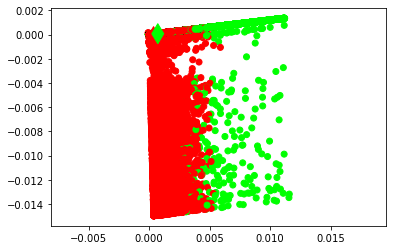

In [71]:
plotCurrent(X_pca_30.to_numpy(), KMeans_pca30.Rnk, KMeans_pca30_Kmus)

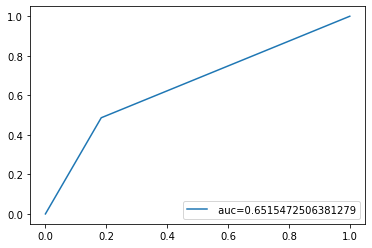

In [118]:
plot_auc(y, KMeans_pca30_pred)

### - train whole X

In [72]:
%%time
KMeans_normc = KMeans(normc(X), 2)
KMeans_Kmus_normc = KMeans_normc.runKMeans()
KMeans_pred_normc = KMeans_normc.predict(normc(X))

CPU times: user 1min 25s, sys: 13.5 s, total: 1min 39s
Wall time: 1min 39s


In [73]:
print("Number of mislabeled points out of a total %d points : %d"
      % (X.shape[0], (y != KMeans_pred_normc).sum()))
print()
print("Accuracy", metrics.accuracy_score(y, KMeans_pred_normc))

Number of mislabeled points out of a total 590540 points : 132321

Accuracy 0.7759321976496089


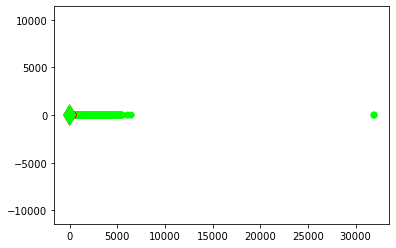

In [74]:
plotCurrent(X.to_numpy(), KMeans_normc.Rnk, KMeans_Kmus_normc)

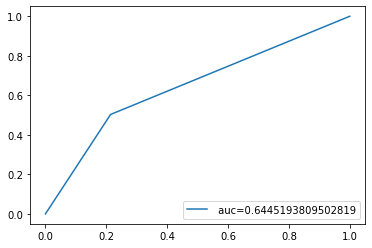

In [119]:
plot_auc(y, KMeans_pred_normc)

# GMM

In [75]:
from sklearn.mixture import GaussianMixture 

### - train first 30 PCA components

In [76]:
%%time
gm_pca_30 = GaussianMixture(n_components=2, random_state=0).fit(X_pca_30)
gm_pca_30_pred = gm_pca_30.predict(X_pca_30)

CPU times: user 1min 6s, sys: 9.12 s, total: 1min 15s
Wall time: 21.1 s


In [95]:
print("Number of mislabeled points out of a total %d points : %d"
      % (X_pca_30.shape[0], (y != gm_pca_30_pred).sum()))
print()
print("Accuracy", metrics.accuracy_score(y, gm_pca_30_pred))

Number of mislabeled points out of a total 590540 points : 36832

Accuracy 0.937629965794019


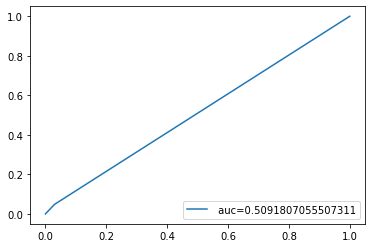

In [120]:
plot_auc(y, gm_pca_30_pred)

### - train whole X

In [78]:
%%time
gm_x = GaussianMixture(n_components=2, random_state=0).fit(X)
gm_x_pred = gm_x.predict(X)

CPU times: user 8min 5s, sys: 4min 16s, total: 12min 22s
Wall time: 8min 2s


In [ ]:
# auc

In [96]:
print("Number of mislabeled points out of a total %d points : %d"
      % (X_pca_30.shape[0], (y != gm_pca_30_pred).sum()))
print()
print("Accuracy", metrics.accuracy_score(y, gm_x_pred))

Number of mislabeled points out of a total 590540 points : 36832

Accuracy 0.7538439394452535


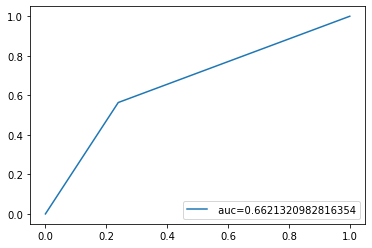

In [122]:
plot_auc(y, gm_x_pred)

## LightGBM
- Light Gradient Boosting Machine
- is a free and open source distributed gradient boosting framework for machine learning originally developed by Microsoft. 

In [92]:
import gc

In [82]:
submit_df = pd.read_csv(f'{folder_path}/sample_submission.csv')

### - train first 30 PCA components

Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.905061	valid_1's auc: 0.858551
[400]	training's auc: 0.937319	valid_1's auc: 0.870063
[600]	training's auc: 0.962073	valid_1's auc: 0.877438
[800]	training's auc: 0.976319	valid_1's auc: 0.882003
[1000]	training's auc: 0.985165	valid_1's auc: 0.884163
[1200]	training's auc: 0.990522	valid_1's auc: 0.885283
[1400]	training's auc: 0.993939	valid_1's auc: 0.886112
[1600]	training's auc: 0.995919	valid_1's auc: 0.886703
[1800]	training's auc: 0.997271	valid_1's auc: 0.887048
[2000]	training's auc: 0.998201	valid_1's auc: 0.887059
[2200]	training's auc: 0.998872	valid_1's auc: 0.887109
[2400]	training's auc: 0.999275	valid_1's auc: 0.887094
[2600]	training's auc: 0.999557	valid_1's auc: 0.88697
Early stopping, best iteration is:
[2115]	training's auc: 0.998595	valid_1's auc: 0.887171
ROC AUC 0.8871712389060196


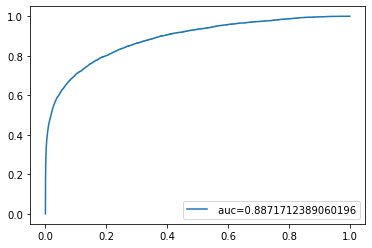

Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.906466	valid_1's auc: 0.859253
[400]	training's auc: 0.938806	valid_1's auc: 0.869991
[600]	training's auc: 0.963164	valid_1's auc: 0.876832
[800]	training's auc: 0.977027	valid_1's auc: 0.880975
[1000]	training's auc: 0.985532	valid_1's auc: 0.882976
[1200]	training's auc: 0.99074	valid_1's auc: 0.883985
[1400]	training's auc: 0.993982	valid_1's auc: 0.884613
[1600]	training's auc: 0.996098	valid_1's auc: 0.884863
[1800]	training's auc: 0.997425	valid_1's auc: 0.885047
[2000]	training's auc: 0.9983	valid_1's auc: 0.885001


KeyboardInterrupt: 

In [125]:
%%time
from sklearn.model_selection import KFold
import lightgbm as lgb
# https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
         }

EPOCHS = 3 #KFLODS
kf = KFold(n_splits = EPOCHS, shuffle = True)
y_preds_gbm = np.zeros(submit_df.shape[0])
# y_oof = np.zeros(X_pca_30.shape[0])
features_importance = []

for train_index, valid_index in kf.split(X_pca_30, y):
    # data separate
    X_train, X_valid = X_pca_30.iloc[train_index, :], X_pca_30.iloc[valid_index, :]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    # train
    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    features_importance.append(clf.feature_importance())
    # test
    y_pred_valid = clf.predict(X_valid)
    
    print('ROC AUC {}'.format(roc_auc_score(y_valid, y_pred_valid)))
    plot_auc(y_valid, y_pred_valid)
    y_preds_gbm += clf.predict(X_test_pca_30) / 3
    
    # save memory
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    

In [84]:
y_preds_gbm

array([0., 0., 0., ..., 0., 0., 0.])

### - train whole X

Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.948027	valid_1's auc: 0.926631
[400]	training's auc: 0.968599	valid_1's auc: 0.942046
[600]	training's auc: 0.982707	valid_1's auc: 0.953181
[800]	training's auc: 0.990053	valid_1's auc: 0.959415
[1000]	training's auc: 0.993921	valid_1's auc: 0.963261
[1200]	training's auc: 0.996086	valid_1's auc: 0.965553
[1400]	training's auc: 0.997354	valid_1's auc: 0.96696
[1600]	training's auc: 0.998179	valid_1's auc: 0.967934
[1800]	training's auc: 0.998723	valid_1's auc: 0.968653
[2000]	training's auc: 0.999099	valid_1's auc: 0.969108
[2200]	training's auc: 0.999383	valid_1's auc: 0.969381
[2400]	training's auc: 0.999578	valid_1's auc: 0.969543
[2600]	training's auc: 0.999728	valid_1's auc: 0.969643
[2800]	training's auc: 0.999817	valid_1's auc: 0.969687
[3000]	training's auc: 0.999875	valid_1's auc: 0.969728
[3200]	training's auc: 0.999915	valid_1's auc: 0.969773
[3400]	training's auc: 0.999943	valid_1's auc: 

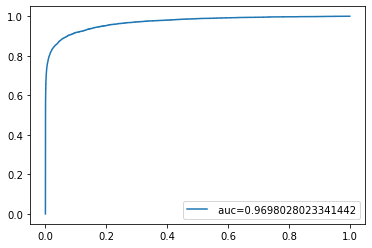

KeyboardInterrupt: 

In [127]:
%%time
from sklearn.model_selection import KFold
import lightgbm as lgb
# https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
         }

EPOCHS = 3 #KFLODS
kf = KFold(n_splits = EPOCHS, shuffle = True)
y_preds_gbm_all = np.zeros(submit_df.shape[0])
# y_oof = np.zeros(X_pca_30.shape[0])
features_importance = []

for train_index, valid_index in kf.split(X, y):
    # data separate
    X_train, X_valid = X.iloc[train_index, :], X.iloc[valid_index, :]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    # train
    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    features_importance.append(clf.feature_importance())
    # test
    y_pred_valid = clf.predict(X_valid)
    
    print('ROC AUC {}'.format(roc_auc_score(y_valid, y_pred_valid)))
    plot_auc(y_valid, y_pred_valid)

    y_preds_gbm_all += clf.predict(X_test) / 3
    
    # save memory
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    

# Neural Network

In [98]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas
import numpy
'''
A simple forward neuron network
Designed to contain only one hidden layer
Used for estimation
Activation function is sigmoid
Loss function is MSE
'''
class NeuronNetwork:
    '''
    input.shape = [sampleNumber, variableNumber, 1]
    target.shape = [sampleNumber, 1, 1]
    '''
    def __init__(self, input, target, hiddenLayerNeuronNumber=32, learningRate=0.1, bias=[0.1,0.2]):
        self.input = input
        self.target = target
        self.hiddenLayerNeuronNumber = hiddenLayerNeuronNumber
        self.learningRate = learningRate
        self.bias = bias

        #initiate parameters
        self.w1 = tf.random.normal([hiddenLayerNeuronNumber, input.shape[1]])
        self.w2 = tf.random.normal([1,hiddenLayerNeuronNumber])
        
    def setLearningRate(self, newRate):
        self.learningRate = newRate
    
    def setBias(self, newBias):
        self.bias = newBias


    def lossFunc(self, predict, target):
        temp = (predict-target)*(predict-target)
        return tf.reduce_sum(temp) / temp.shape[0]

    '''
    input.shape = [batchSize, variableNumber, 1]
    target.shape = [batchSize, 1, 1]
    '''
    def trainOneStep(self, input, target):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch([self.w1, self.w2])
            hiddenOut = tf.sigmoid(tf.add(tf.matmul(self.w1, input), self.bias[0]))
            output = tf.sigmoid(tf.add(tf.matmul(self.w2, hiddenOut), self.bias[1]))
            loss = self.lossFunc(output, target)
        g1 = tape.gradient(loss, self.w1)
        g2 = tape.gradient(loss, self.w2)
        self.w1 = self.w1 - self.learningRate*g1
        self.w2 = self.w2 - self.learningRate*g2

    def calculateTotalLoss(self):
        hiddenOut = tf.sigmoid(tf.add(tf.matmul(self.w1, self.input), self.bias[0]))
        output = tf.sigmoid(tf.add(tf.matmul(self.w2, hiddenOut), self.bias[1]))
        loss = self.lossFunc(output, self.target)
        return loss

    def train(self, epoch = 128, batchSize = 128, targetLoss = 0.001):
        for i in range(epoch):
            currentPlace = 0
            averageLoss = 0
            stepCount = 0
            while True:
                if currentPlace + batchSize > self.input.shape[0]-1:
                    #will exceed the dataset
                    self.trainOneStep(self.input[currentPlace:,:,:], self.target[currentPlace:,:,:])
                    break
                else:
                    self.trainOneStep(self.input[currentPlace:currentPlace+batchSize,:,:], self.target[currentPlace:currentPlace+batchSize,:,:])
                    currentPlace += batchSize
            loss = self.calculateTotalLoss()
            print("Epoch: ", i+1, "; Loss:", end="")
            print(loss)
            if loss < targetLoss:
                return
    
    def predict(self, input):
        hiddenOut = tf.sigmoid(tf.add(tf.matmul(self.w1, input), self.bias[0]))
        output = tf.sigmoid(tf.add(tf.matmul(self.w2, hiddenOut), self.bias[1]))
        return output

In [ ]:
# %%time
# EPOCHS = 3 #KFLODS
# kf = KFold(n_splits = EPOCHS, shuffle = True)
# y_preds_nw = np.zeros(submit_df.shape[0])


# for train_index, valid_index in kf.split(X_pca_30, y):
#     # data separate
#     X_train, X_valid = X_pca_30.iloc[train_index, :], X_pca_30.iloc[valid_index, :]
#     y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
#     # Transform
#     trainX = numpy.reshape(X_train.to_numpy(), [X_train.shape[0], X_train.shape[1]])
#     trainY = numpy.reshape(y_train.to_numpy(), [y_train.shape[0]])
#     trainY = tf.one_hot(trainY, 2)
    
#     validX = numpy.reshape(X_valid.to_numpy(), [X_valid.shape[0], X_valid.shape[1]])
#     validY = numpy.reshape(y_valid.to_numpy(), [y_valid.shape[0]])
#     validY = tf.one_hot(trainY, 2)
#     # train
#     model = keras.Sequential(
#         [
#             layers.Dense(64, activation='relu'),
#             layers.Dense(2, activation='softmax')
#         ]
#     )
    
#     log_dir="tensorboard_log"
#     tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     model.fit(trainX, trainY,batch_size=128,epochs=2, validation_split=0.25, callbacks=[tensorboard])
#     # test
#     y_pred_valid = model.predict(validX)
#     # y_pred_valid = numpy.argmax(y_pred_valid, axis=1)
    
#     print('ROC AUC {}'.format(roc_auc_score(validY, y_pred_valid)))
#     y_preds_nw += model.predict(X_test) / 3
    
#     # save memory
#     del X_train, X_valid, y_train, y_valid, trainX, trainY, validX, validY
#     gc.collect()

### Submit Kaggle Private Test

In [ ]:
# submit_df = pd.read_csv(f'{folder_path}/sample_submission.csv')
# submit_df['isFraud'] = gnb.predict(X_test_pca_30)

In [ ]:
# submit_df[submit_df['isFraud']==1]

In [ ]:
# submit_df[submit_df['isFraud']==1]

In [ ]:
# submit_df.to_csv('submit_118b.csv', index=False)

# Discussion

Shown in the report

In [129]:
d = {'algorithms': ['KMeans', 'GMM', 'Neural Network', 'LightGBM'],\
     'PCA30 AUC': [0.652, 0.509, 0.50, 0.887],\
     'Whole X': [0.645, 0.662, 0.66, 0.969]}
df = pd.DataFrame(data=d)

In [130]:
df

,algorithms,PCA30 AUC,Whole X
0,KMeans,0.652,0.645
1,GMM,0.509,0.662
2,Neural Network,0.500,0.660
3,LightGBM,0.887,0.969
